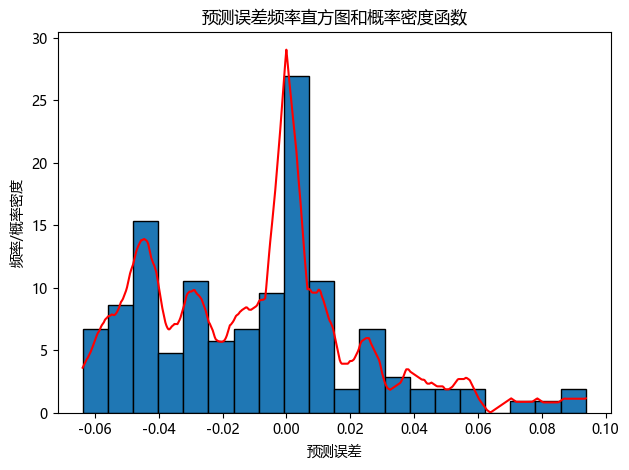

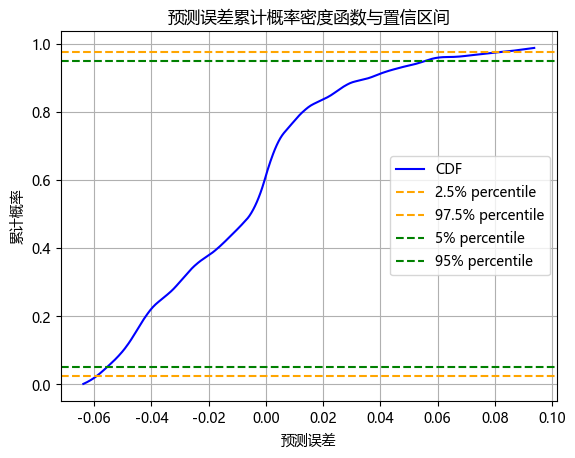

90% PICP: 0.8863636363636364
90% PINAW: 0.11118099033266535
95% PICP: 0.9545454545454546
95% PINAW: 0.14055551334669342
90% PINMW: 0.0016409075918293145
95% PINMW: 0.0020744428362614916
90% CWC: 0.0031577231880391826
95% CWC: 0.0020744428362614916


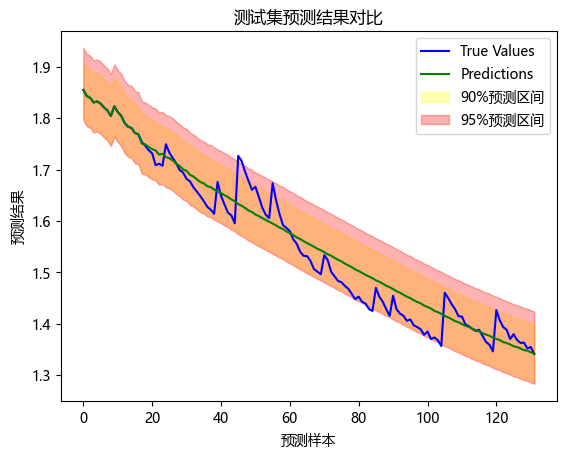

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
# 读取数据
result = pd.read_csv('0018.csv', encoding= "gbk")
pred = result['pred1']
T = result['真实值']
stopline = result['失效阈值']

# 计算确定性预测误差
error = T - pred
# mse = np.mean(error**2)
# mae = np.mean(np.abs(error))
#
# print(f'确定性预测误差指标:')
# print(f'MSE: {mse:.4f}')
# print(f'MAE: {mae:.4f}')

"""点预测1时，h设置为0.2"""
def triangle_kernel(x):
    return np.maximum(0, 1 - np.abs(x))
density = lambda x: np.mean([triangle_kernel((x - e) / h) for e in error], axis=0) / h
h = 0.2 * np.std(error)  #pred1（多步）的时候0.2 ； pred2（单步）的时候0.2~0.3
x = np.linspace(error.min(), error.max(), 500)
pdf = density(x)


## 图1 预测误差频率直方图和概率密度函数
plt.figure()
plt.hist(error, bins=20, density=True, edgecolor='black')
plt.plot(x, pdf, color='r')
plt.title('预测误差频率直方图和概率密度函数')
plt.xlabel('预测误差')
plt.ylabel('频率/概率密度')
plt.tight_layout()
plt.show()


##图2 预测误差累计概率密度函数与置信区间
# # 计算累计概率密度函数（CDF）
cdf = np.cumsum(pdf) * (x[1] - x[0])
# 画出CDF
plt.figure()
plt.plot(x, cdf, label='CDF', color='blue')
# 置信区间对应的CDF值 (90%和95%)
ci_90 = (1 - 0.90) / 2, 1 - (1 - 0.90) / 2
ci_95 = (1 - 0.95) / 2, 1 - (1 - 0.95) / 2

# 在置信区间的边界处画水平线
plt.axhline(y=ci_95[0], color='orange', linestyle='--', label='2.5% percentile')
plt.axhline(y=ci_95[1], color='orange', linestyle='--', label='97.5% percentile')
plt.axhline(y=ci_90[0], color='green', linestyle='--', label='5% percentile')
plt.axhline(y=ci_90[1], color='green', linestyle='--', label='95% percentile')

# 添加图例、标题和轴标签
plt.title('预测误差累计概率密度函数与置信区间')
plt.xlabel('预测误差')
plt.ylabel('累计概率')
plt.legend()
plt.grid(True)
plt.show()

def prediction_interval(pdf, x, confidence=0.95):
    cdf = np.cumsum(pdf) * (x[1] - x[0])
    credibility_interval = (1 - confidence) / 2
    lower_bound = x[np.argmax(cdf > credibility_interval)]
    upper_bound = x[np.argmax(cdf > 1 - credibility_interval) - 1]
    return lower_bound, upper_bound

# 计算90%和95%预测区间
lower_90, upper_90 = prediction_interval(pdf, x, confidence=0.90)
lower_95, upper_95 = prediction_interval(pdf, x, confidence=0.95)

# 计算PICP和PINAW
interval_coverage_90 = np.mean((T >= pred + lower_90) & (T <= pred + upper_90))
interval_width_90 = upper_90 - lower_90

interval_coverage_95 = np.mean((T >= pred + lower_95) & (T <= pred + upper_95))
interval_width_95 = upper_95 - lower_95

print(f"90% PICP: {interval_coverage_90}")
print(f"90% PINAW: {interval_width_90}")
print(f"95% PICP: {interval_coverage_95}")
print(f"95% PINAW: {interval_width_95}")




# 计算PINMW
C_max = pred.max()
C_min = pred.min()
K = len(pred)

pinmw_90 = (1 / ((C_max - C_min) * K)) * np.sum(upper_90 - lower_90)
pinmw_95 = (1 / ((C_max - C_min) * K)) * np.sum(upper_95 - lower_95)

print(f"90% PINMW: {pinmw_90}")
print(f"95% PINMW: {pinmw_95}")

# 计算CWC
alpha = 0.90
rho = 0.1
delta_90 = 1 if interval_coverage_90 < alpha else 0
delta_95 = 1 if interval_coverage_95 < alpha else 0

cwc_90 = pinmw_90 * (1 + delta_90 * np.exp(-rho * (interval_coverage_90 - 1 + alpha)))
cwc_95 = pinmw_95 * (1 + delta_95 * np.exp(-rho * (interval_coverage_95 - 1 + alpha)))

print(f"90% CWC: {cwc_90}")
print(f"95% CWC: {cwc_95}")





##图3 绘制全局预测区间图
plt.figure()
index = np.arange(len(pred))
plt.plot(index, T, color='blue', label='True Values')
plt.plot(index, pred, color='green', label='Predictions')

plt.fill_between(index, pred + lower_90, pred + upper_90, color='yellow', alpha=0.3, label='90%预测区间')
plt.fill_between(index, pred + lower_95, pred + upper_95, color='red', alpha=0.3, label='95%预测区间')

plt.title('测试集预测结果对比')
plt.xlabel('预测样本')
plt.ylabel('预测结果')
plt.legend()
plt.show()

# ##图4 局部预测区间绘制 
# # 截取部分点
# start_index = 0
# end_index = 167

# # Slicing the data for the specified range
# index_range = np.arange(start_index, end_index + 1)
# T_range = T[start_index:end_index + 1]
# pred_range = pred[start_index:end_index + 1]
# stopline_range = stopline[start_index:end_index + 1]

# # Plotting
# plt.figure(figsize=(12, 6))
# plt.plot(index_range, T_range, color='c', label='True Values')
# plt.plot(index_range, pred_range, color='green', label='Predictions')
# plt.plot(index_range, stopline_range, color='black', ls=':', label='Predictions')
# plt.fill_between(index_range, pred_range + lower_90, pred_range + upper_90, color='green', alpha=0.3, label='90% Prediction Interval')
# plt.fill_between(index_range, pred_range + lower_95, pred_range + upper_95, color='blue', alpha=0.3, label='95% Prediction Interval')

# plt.title('Global Prediction Intervals ')
# plt.xlabel('Index')
# plt.ylabel('Values')
# plt.legend()
# plt.show()

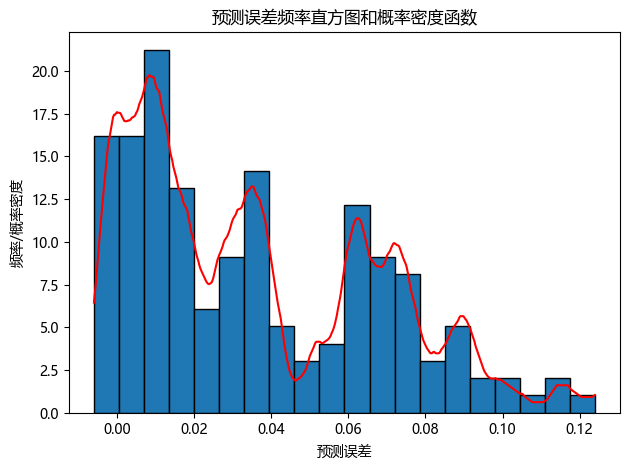

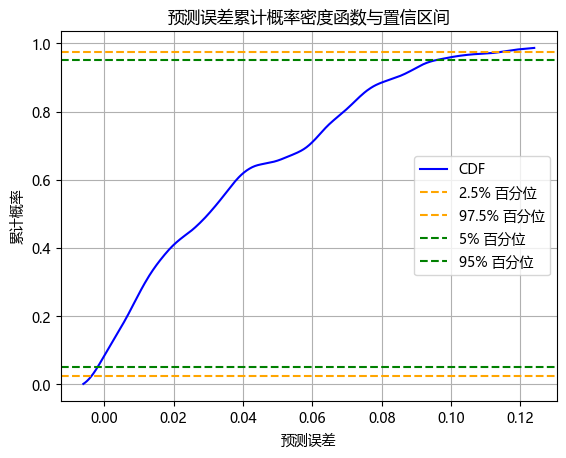

90% PICP: 0.9013157894736842
90% PINAW: 0.09720173766132248
95% PICP: 0.9671052631578947
95% PINAW: 0.11778870086573126
90% PINMW: 0.0011428971717038743
95% PINMW: 0.0013849585029762767
90% CWC: 0.0011428971717038743
95% CWC: 0.0013849585029762767


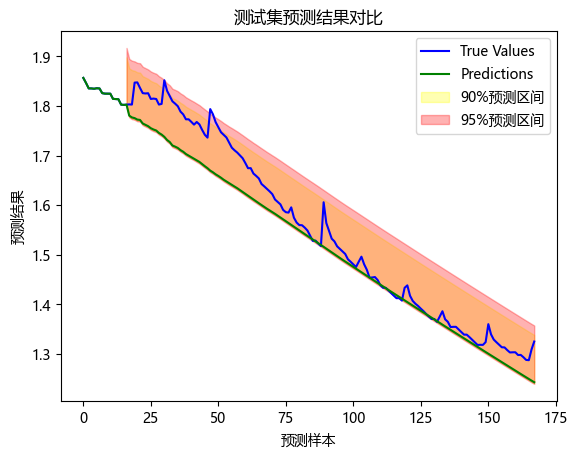

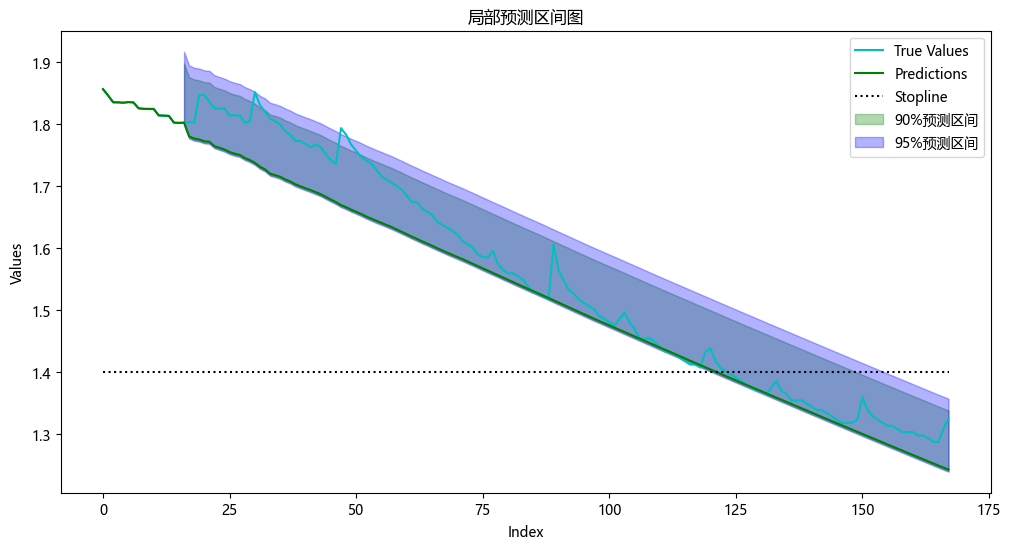

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
# 读取数据
result = pd.read_csv('0005.csv', encoding="gbk")
pred = result['pred1']
T = result['真实值']
stopline = result['失效阈值']

# 从第17个数据点开始取值进行预测误差分析
pred_analysis = pred[16:].reset_index(drop=True)
T_analysis = T[16:].reset_index(drop=True)
stopline_analysis = stopline[16:].reset_index(drop=True)

# 计算确定性预测误差
error = T_analysis - pred_analysis

"""点预测1时，h设置为0.2"""
def triangle_kernel(x):
    return np.maximum(0, 1 - np.abs(x))
density = lambda x: np.mean([triangle_kernel((x - e) / h) for e in error], axis=0) / h
h = 0.2 * np.std(error)  # pred1（多步）的时候0.2 ； pred2（单步）的时候0.2~0.3
x = np.linspace(error.min(), error.max(), 500)
pdf = density(x)

# 图1 预测误差频率直方图和概率密度函数
plt.figure()
plt.hist(error, bins=20, density=True, edgecolor='black')
plt.plot(x, pdf, color='r')
plt.title('预测误差频率直方图和概率密度函数')
plt.xlabel('预测误差')
plt.ylabel('频率/概率密度')
plt.tight_layout()
plt.show()

# 图2 预测误差累计概率密度函数与置信区间
cdf = np.cumsum(pdf) * (x[1] - x[0])
plt.figure()
plt.plot(x, cdf, label='CDF', color='blue')
ci_90 = (1 - 0.90) / 2, 1 - (1 - 0.90) / 2
ci_95 = (1 - 0.95) / 2, 1 - (1 - 0.95) / 2
plt.axhline(y=ci_95[0], color='orange', linestyle='--', label='2.5% 百分位')
plt.axhline(y=ci_95[1], color='orange', linestyle='--', label='97.5% 百分位')
plt.axhline(y=ci_90[0], color='green', linestyle='--', label='5% 百分位')
plt.axhline(y=ci_90[1], color='green', linestyle='--', label='95% 百分位')
plt.title('预测误差累计概率密度函数与置信区间')
plt.xlabel('预测误差')
plt.ylabel('累计概率')
plt.legend()
plt.grid(True)
plt.show()

def prediction_interval(pdf, x, confidence=0.95):
    cdf = np.cumsum(pdf) * (x[1] - x[0])
    credibility_interval = (1 - confidence) / 2
    lower_bound = x[np.argmax(cdf > credibility_interval)]
    upper_bound = x[np.argmax(cdf > 1 - credibility_interval) - 1]
    return lower_bound, upper_bound

# 计算90%和95%预测区间
lower_90, upper_90 = prediction_interval(pdf, x, confidence=0.90)
lower_95, upper_95 = prediction_interval(pdf, x, confidence=0.95)

# 计算PICP和PINAW
interval_coverage_90 = np.mean((T_analysis >= pred_analysis + lower_90) & (T_analysis <= pred_analysis + upper_90))
interval_width_90 = upper_90 - lower_90

interval_coverage_95 = np.mean((T_analysis >= pred_analysis + lower_95) & (T_analysis <= pred_analysis + upper_95))
interval_width_95 = upper_95 - lower_95

print(f"90% PICP: {interval_coverage_90}")
print(f"90% PINAW: {interval_width_90}")
print(f"95% PICP: {interval_coverage_95}")
print(f"95% PINAW: {interval_width_95}")

# 计算PINMW
C_max = pred_analysis.max()
C_min = pred_analysis.min()
K = len(pred_analysis)

pinmw_90 = (1 / ((C_max - C_min) * K)) * np.sum(upper_90 - lower_90)
pinmw_95 = (1 / ((C_max - C_min) * K)) * np.sum(upper_95 - lower_95)

print(f"90% PINMW: {pinmw_90}")
print(f"95% PINMW: {pinmw_95}")

# 计算CWC
alpha = 0.90
rho = 0.1
delta_90 = 1 if interval_coverage_90 < alpha else 0
delta_95 = 1 if interval_coverage_95 < alpha else 0

cwc_90 = pinmw_90 * (1 + delta_90 * np.exp(-rho * (interval_coverage_90 - 1 + alpha)))
cwc_95 = pinmw_95 * (1 + delta_95 * np.exp(-rho * (interval_coverage_95 - 1 + alpha)))

print(f"90% CWC: {cwc_90}")
print(f"95% CWC: {cwc_95}")

# 图3 全局预测区间图
plt.figure()
index = np.arange(len(pred))
plt.plot(index, T, color='blue', label='True Values')
plt.plot(index, pred, color='green', label='Predictions')
plt.fill_between(index[16:], pred[16:] + lower_90, pred[16:] + upper_90, color='yellow', alpha=0.3, label='90%预测区间')
plt.fill_between(index[16:], pred[16:] + lower_95, pred[16:] + upper_95, color='red', alpha=0.3, label='95%预测区间')
plt.title('测试集预测结果对比')
plt.xlabel('预测样本')
plt.ylabel('预测结果')
plt.legend()
plt.show()

# 图4 局部预测区间绘制
start_index = 0
end_index = 167  # 调整局部区间的结束索引，根据需要进行调整
index_range = np.arange(start_index, end_index + 1)
T_range = T[start_index:end_index + 1]
pred_range = pred[start_index:end_index + 1]
stopline_range = stopline[start_index:end_index + 1]

plt.figure(figsize=(12, 6))
plt.plot(index_range, T_range, color='c', label='True Values')
plt.plot(index_range, pred_range, color='green', label='Predictions')
plt.plot(index_range, stopline_range, color='black', ls=':', label='Stopline')
plt.fill_between(index_range[16:], pred_range[16:] + lower_90, pred_range[16:] + upper_90, color='green', alpha=0.3, label='90%预测区间')
plt.fill_between(index_range[16:], pred_range[16:] + lower_95, pred_range[16:] + upper_95, color='blue', alpha=0.3, label='95%预测区间')
plt.title('局部预测区间图')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

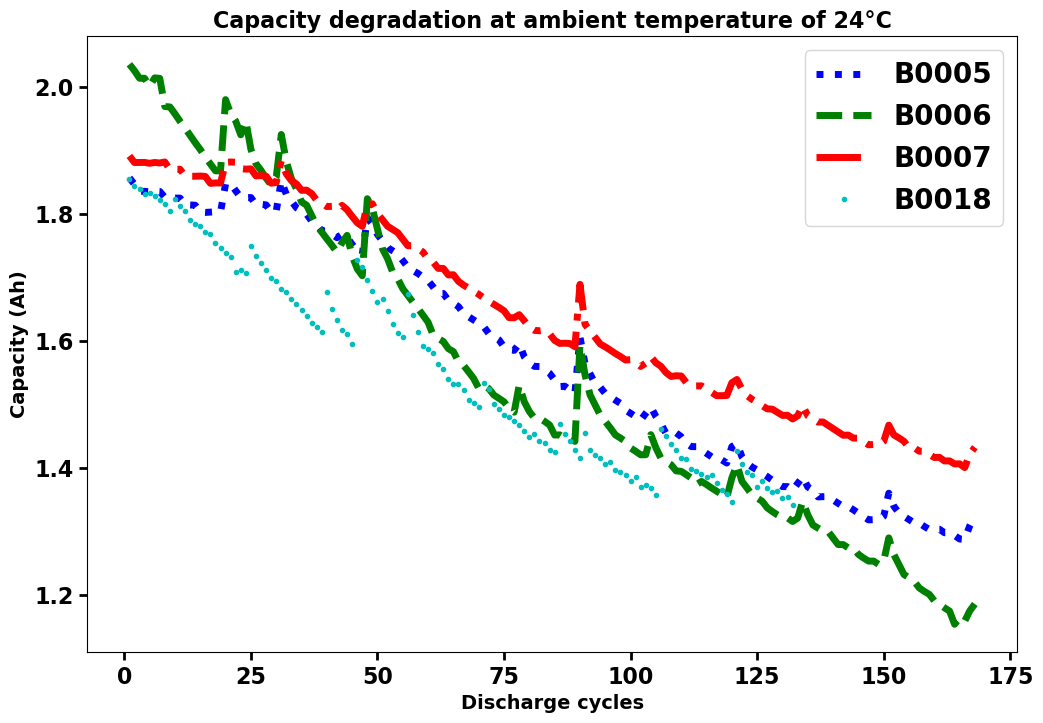

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
Battery = np.load('NASA.npy', allow_pickle=True)
Battery = Battery.item()

fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
c = 0
for name, color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result[0], df_result[1], color, label=name, linewidth=5)  # Increase the line width

# Set labels, title with bold font
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
ax.xaxis.label.set_size(14)
ax.xaxis.label.set_weight('bold')
ax.yaxis.label.set_size(14)
ax.yaxis.label.set_weight('bold')
ax.title.set_size(16)
ax.title.set_weight('bold')

# Set legend with bold font
plt.legend(prop={'weight': 'bold', 'size': 20})

# Set tick parameters to make them bold
ax.tick_params(axis='both', which='major', labelsize=16, width=2, length=6)
ax.tick_params(axis='both', which='minor', labelsize=16, width=2, length=4)
for tick in ax.get_xticklabels():
    tick.set_weight('bold')
for tick in ax.get_yticklabels():
    tick.set_weight('bold')

plt.show()

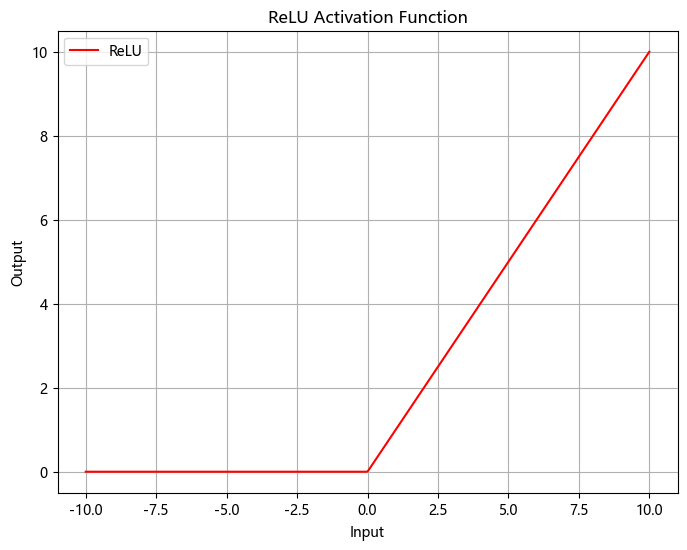

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Define the input range
x = np.linspace(-10, 10, 400)

# Define the ReLU activation function
def relu(x):
    return np.maximum(0, x)

# Compute the ReLU activation
y_relu = relu(x)

# Plot the ReLU activation function
plt.figure(figsize=(8, 6))
plt.plot(x, y_relu, label="ReLU", color="red")
plt.title("ReLU Activation Function")
plt.xlabel("Input")
plt.ylabel("Output")
plt.grid()
plt.legend()
plt.show()

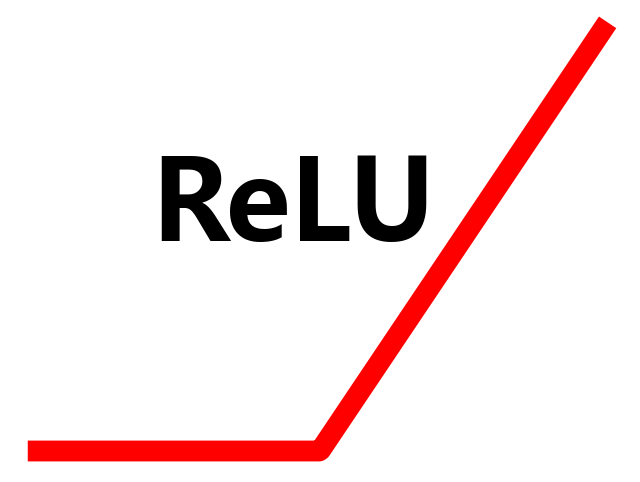

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Define the input range
x = np.linspace(-10, 10, 400)

# Define the ReLU activation function
def relu(x):
    return np.maximum(0, x)

# Compute the ReLU activation
y_relu = relu(x)

# Plot the ReLU activation function without grid and thicker line
plt.figure(figsize=(8, 6))
plt.plot(x, y_relu, color="red", linewidth=15)  # Increase line width
plt.text(-6, 5, 'ReLU', fontsize=80, color='black', weight='bold')  # Add text near the line
plt.axis('off')  # Turn off the axis
plt.show()

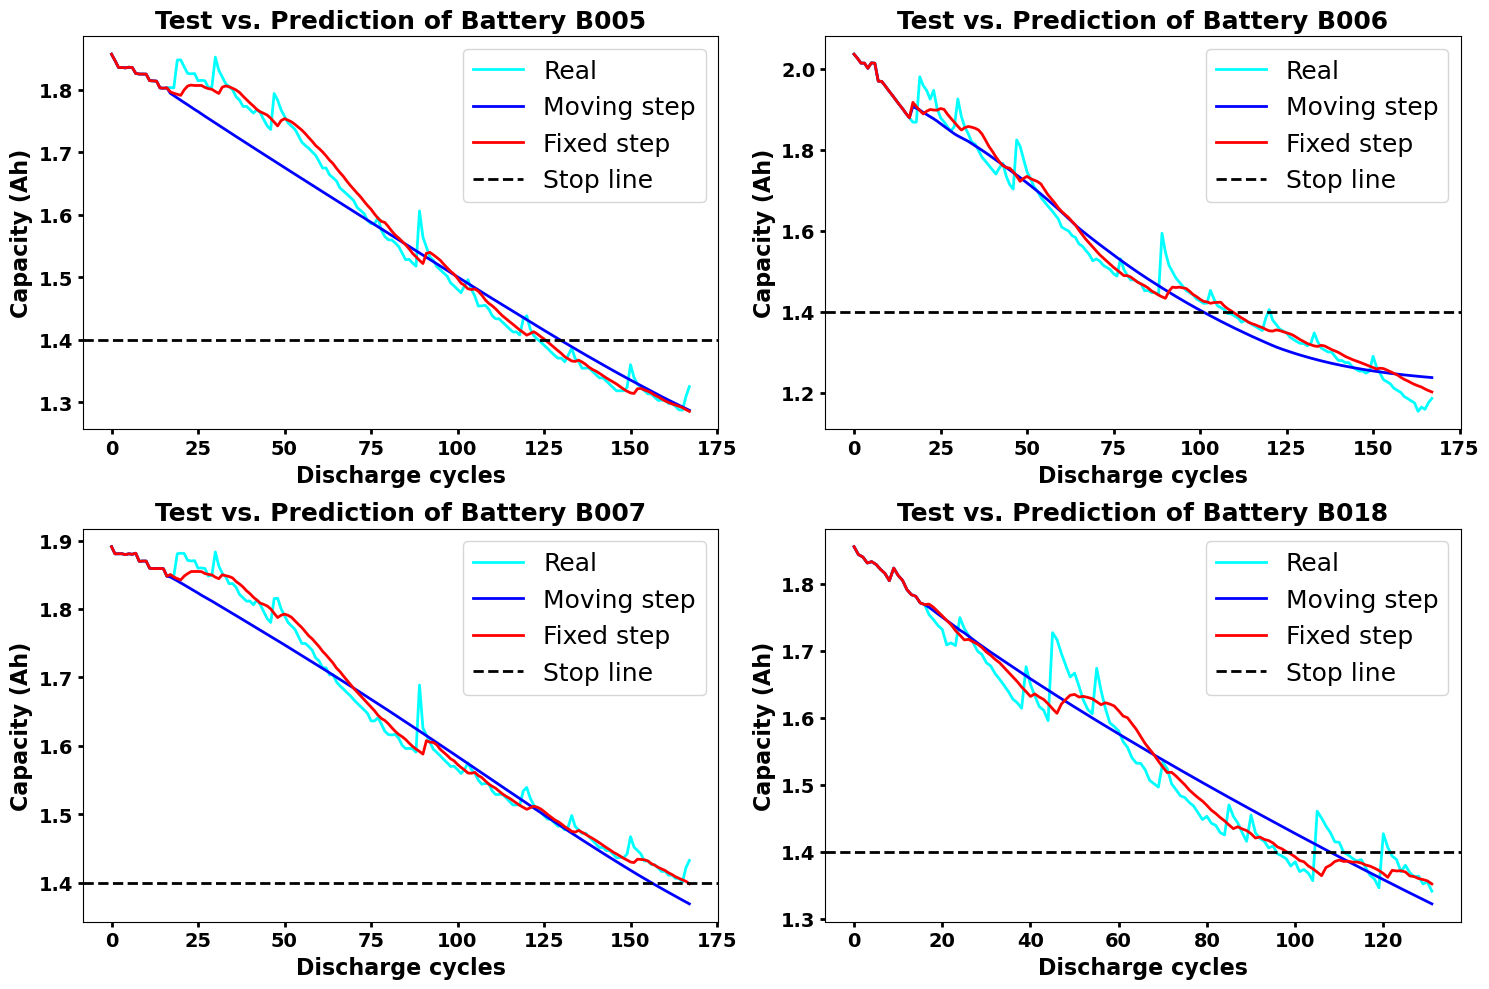

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件
file_paths = [
    '1.csv',  # 替换为实际路径
    '2.csv',  # 替换为实际路径
    '3.csv',  # 替换为实际路径
    '4.csv',   # 替换为实际路径
]

# 读取CSV文件为DataFrame
dfs = [pd.read_csv(file_path) for file_path in file_paths]

# 绘制数据
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

titles = ['Battery B005', 'Battery B006', 'Battery B007', 'Battery B018']

for i, ax in enumerate(axs.flatten()):
    df = dfs[i]
    ax.plot(df['x'], df['test_data'], label='Real', color='cyan', linewidth=2)
    ax.plot(df['x'], df['pred1'], label='Moving step', color='blue', linewidth=2)
    ax.plot(df['x'], df['pred2'], label='Fixed step', color='red', linewidth=2)
    ax.axhline(y=df['threshold'].iloc[0], color='black', linestyle='--', linewidth=2, label='Stop line')
    ax.set_title(f'Test vs. Prediction of {titles[i]}', fontsize=18, fontweight='bold')
    ax.set_xlabel('Discharge cycles', fontsize=16, fontweight='bold')
    ax.set_ylabel('Capacity (Ah)', fontsize=16, fontweight='bold')
    ax.legend(fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14, width=2)
    for tick in ax.get_xticklabels():
        tick.set_fontsize(14)
        tick.set_fontweight('bold')
    for tick in ax.get_yticklabels():
        tick.set_fontsize(14)
        tick.set_fontweight('bold')

plt.tight_layout()
plt.show()

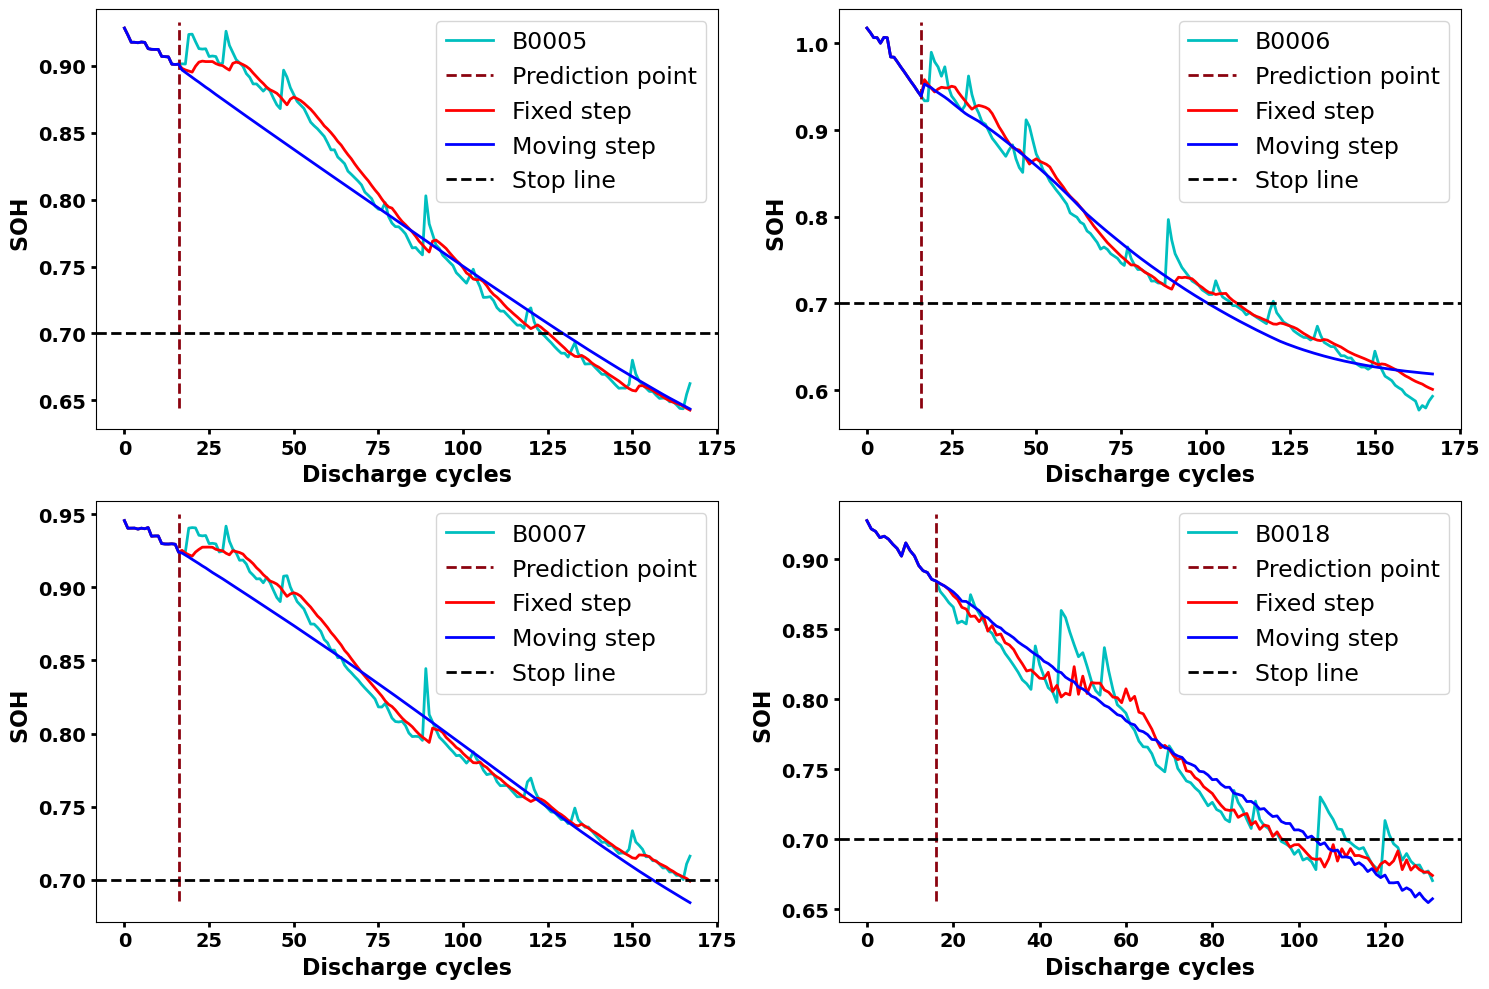

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件
file_paths = [
    '1.csv',  # 替换为实际路径
    '2.csv',  # 替换为实际路径
    '3.csv',  # 替换为实际路径
    '4.csv',   # 替换为实际路径
]

# 读取CSV文件为DataFrame
dfs = [pd.read_csv(file_path) for file_path in file_paths]

# 绘制数据
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

titles = ['Battery B0005', 'Battery B0006', 'Battery B0007', 'Battery B0018']
titles2 = ['B0005', 'B0006', 'B0007', 'B0018']

for i, ax in enumerate(axs.flatten()):
    df = dfs[i]
        
    ax.plot(df['x'], df['test_data']/2, label=titles2[i], color='c', linewidth=2)
    
    # 添加预测点虚线，只在一部分长度上
    prediction_point_index = 16
    if len(df['x']) > prediction_point_index:
        prediction_x = df['x'].iloc[prediction_point_index]
        ax.plot([prediction_x, prediction_x], [0.05, 0.97], transform=ax.get_xaxis_transform(), color='#8B030F', linestyle='--', linewidth=2, label='Prediction point')
        
    ax.plot(df['x'], df['pred2']/2, label='Fixed step', color='red', linewidth=2)
    ax.plot(df['x'], df['pred1']/2, label='Moving step', color='blue', linewidth=2)
    ax.axhline(y=df['threshold'].iloc[0] / 2, color='black', linestyle='--', linewidth=2, label='Stop line')
    
#     ax.set_title(f'Test vs. Prediction of {titles[i]}', fontsize=18, fontweight='bold')
    ax.set_xlabel('Discharge cycles', fontsize=16, fontweight='bold')
    ax.set_ylabel('SOH ', fontsize=16, fontweight='bold')
    ax.legend(fontsize=17)
    ax.tick_params(axis='both', which='major', labelsize=14, width=2)
    for tick in ax.get_xticklabels():
        tick.set_fontsize(14)
        tick.set_fontweight('bold')
    for tick in ax.get_yticklabels():
        tick.set_fontsize(14)
        tick.set_fontweight('bold')

plt.tight_layout()
plt.savefig('预测1_nasa.pdf')  # 保存为PDF文件
plt.show()

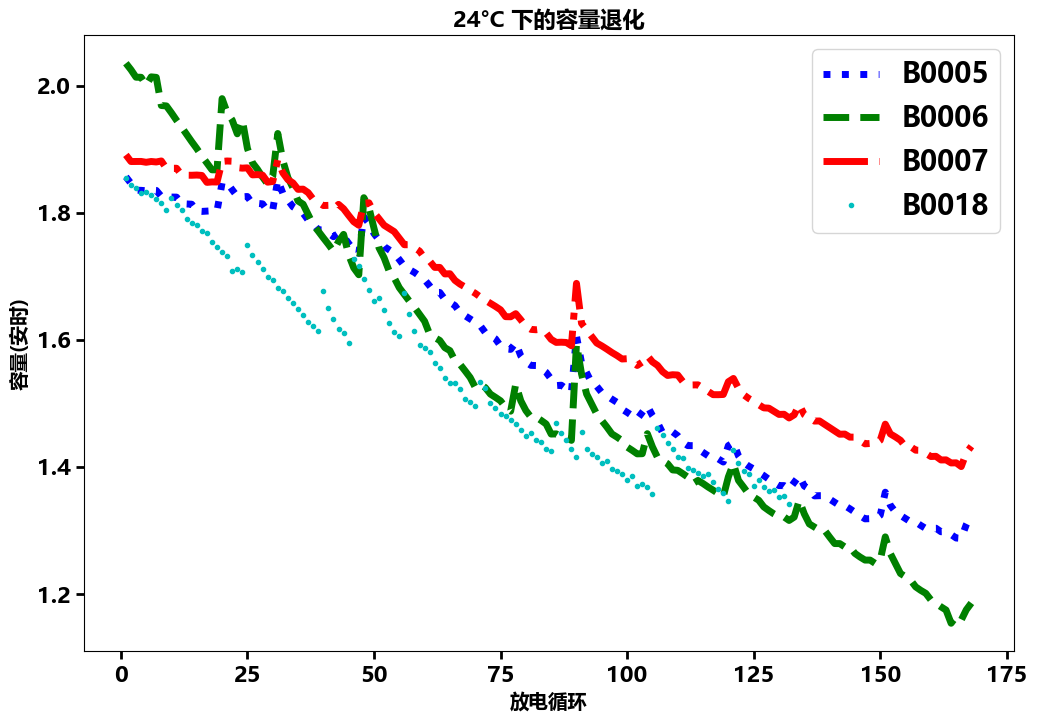

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
Battery = np.load('NASA.npy', allow_pickle=True)
Battery = Battery.item()

fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
c = 0
for name, color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result[0], df_result[1], color, label=name, linewidth=5)  # Increase the line width

# Set labels, title with bold font
ax.set(xlabel='放电循环', ylabel='容量(安时)', title='24°C 下的容量退化')
ax.xaxis.label.set_size(14)
ax.xaxis.label.set_weight('bold')
ax.yaxis.label.set_size(14)
ax.yaxis.label.set_weight('bold')
ax.title.set_size(16)
ax.title.set_weight('bold')

# Set legend with bold font
plt.legend(prop={'weight': 'bold', 'size': 20})

# Set tick parameters to make them bold
ax.tick_params(axis='both', which='major', labelsize=16, width=2, length=6)
ax.tick_params(axis='both', which='minor', labelsize=16, width=2, length=4)
for tick in ax.get_xticklabels():
    tick.set_weight('bold')
for tick in ax.get_yticklabels():
    tick.set_weight('bold')

plt.show()